# Visualize arbitrary SELECTED_OUTPUT files

The RO PHREEQC simulations generate text files of data. The following code imports the text files, intelligently parses the data, and creates visualizations of the data based upon the user intentions of investigating Brine or Scaling. The Brine outputs are a data table of average elemental concentrations at each time interval of the output file. The Scaling outputs are a figure that depicts the moles of scale that exist over the RO module for each time interval. The output figures can then be exported in the user-selected format and saved in the save user directory as this code file.

What is the name of the SELECTED_OUTPUT file?
Exclude the < .txt > suffix to the file name.test_file, Scaling
Would you like to export the figure?
    < y > or < n >n


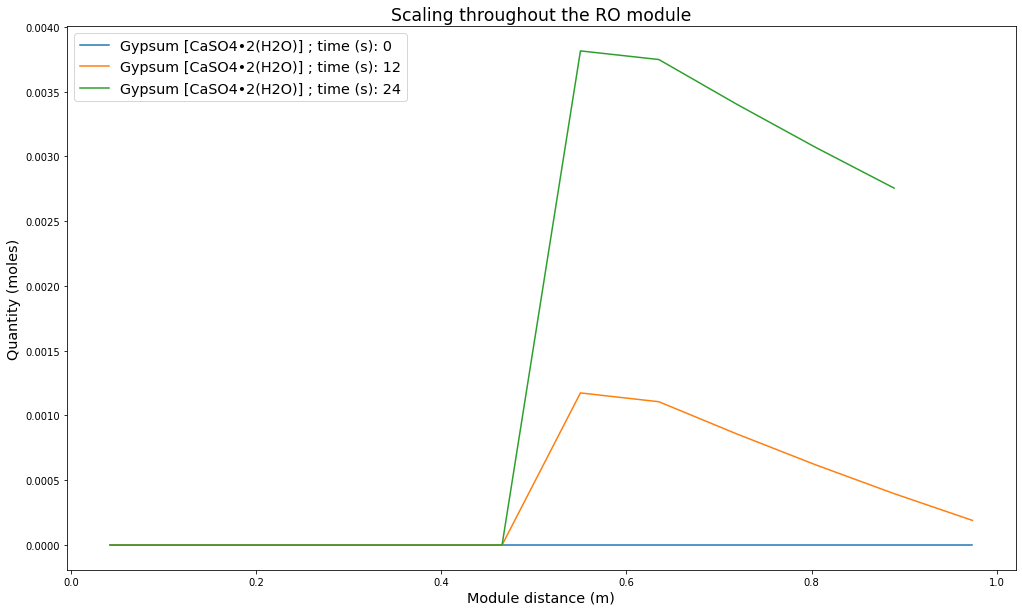

In [15]:
#import libraries
import pandas
import matplotlib.pyplot as pyplot
import re
import os


#import the SELECTED_OUTPUT file   
basic_file_name = input('''What is the name of the SELECTED_OUTPUT file?
Exclude the < .txt > suffix to the file name.''')
while re.search('(\.txt)', basic_file_name):
    print('ERROR: The < .txt > suffix must be removed from the file name.')  
    file_name = input('What is the name of the SELECTED_OUTPUT file?')
file_name = basic_file_name  + '.txt'
while not os.path.exists(file_name):
    print('ERROR: The SELECTED_OUTPUT file is missing from the current directory.')  
    basic_file_name = input('What is the name of the SELECTED_OUTPUT file?')  
    file_name = basic_file_name  + '.txt'
    
#preparing the SELECTED_OUTPUT file into a dataframe
original_data = pandas.read_table(file_name,sep = '\t')
csv_data = pandas.DataFrame(original_data)
for column in csv_data.columns:
    new_column = column.strip()
    csv_data.rename(columns={column:new_column}, inplace = True)  
    
    
#==============================================================================

def process_selected_output():
    graphical_selection = input('''Would you like to view the output brine or the module scaling?
    < Brine > or < Scaling >''')
    while graphical_selection != 'Brine' and graphical_selection != 'Scaling':
        print('''ERROR: The value is not one of the options.
        Select one of the choices to proceed.''')  
        graphical_selection = input('''Would you like to view brine over time in the module, 
        or would your like to view scaling over distance in the module?
        < Brine > or < Scaling >''')
    if graphical_selection == 'Brine':
        make_brine_plot()
    elif graphical_selection == 'Scaling':
        make_scaling_plot()
        
        
def make_brine_plot():
    elements = []
    for column in csv_data.columns:
        if re.search('([A-Z][a-z]?(\(\d\))?){1}$', column) and not re.search('(_|H2O|pH)', column):
            elements.append(column)

    csv_data.drop(csv_data.index[:3], inplace=True)

    unit = 'mol/kgw'
    concentration_array = []
    pyplot.figure(figsize = (17,10))
    pyplot.title('Effluent brine elemental concentrations', fontsize = 'xx-large')
    for element in elements:            
        pyplot.plot(csv_data['time'],csv_data[element])
        pyplot.xlabel('time (s)', fontsize = 'x-large')
        pyplot.ylabel('concentration (%s)' %(unit), fontsize = 'x-large')
        pyplot.grid(True)

    plot_caption = '''\n\nBrine Figure:\n%s 
    The effluent brine concentrations of each existing element. Scaling data through the Brine plotting will
    generate vertical concentrations at each defined time. The veritical concentrations represent the concentration
    distributions throughout the RO module at the specified time, where the low boundary is the concentration at
    the entrance of the module while the high boundary is the concentration at the exit of the module.''' %('='*len('Brine Figure'))

    pyplot.legend(elements, loc='best', title = 'non-zero elements', fontsize = 'x-large')
    print(plot_caption)

    #pyplot.figtext(0.2, 0, plot_caption, wrap=True, horizontalalignment='left', fontsize=12)


    #define a summarizing table of the concentration averages
    loop_iteration = 1
    table_view = {}
    average_concentrations_table = pandas.DataFrame()
    for element in elements:
        quantity_of_steps_index = 0
        average_iteration = 1
        time_serie = []            
        time_averages = {}
        for index, row in csv_data.iterrows():
            if csv_data.at[index, 'time'] == 0:
                time_serie.append(csv_data.at[index,element])                 
                quantity_of_steps_index += 1                    

            elif csv_data.at[index-1,'soln'] == quantity_of_steps_index:       
                #process the complete time serie
                try:
                    average_concentration = sum(time_serie) / len(time_serie)
                except:
                    average_concentration = 0
                #print(average_concentration)
                table_view['Time: %s' %(average_iteration)] = {}
                table_view['Time: %s' %(average_iteration)][element] = [average_concentration]
                average_iteration += 1
                #print('mid-End')   

                #begin the new time serie
                time_serie = []
                time_averages = {}
                time_serie.append(csv_data.at[index,element])
                #print('middle')    

            elif index == len(csv_data[element]) + 2:       
                time_serie.append(csv_data.at[index,element])            
                try:
                    average_concentration = sum(time_serie) / len(time_serie)
                except:
                    average_concentration = 0
                table_view['Time: %s' %(average_iteration)] = {}
                table_view['Time: %s' %(average_iteration)][element] = [average_concentration]
                average_iteration += 1
                #print('end-End')  

                average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
                loop_iteration += 1

            else:
                #print('middle')      
                time_serie.append(csv_data.at[index,element])


        #print(element)

    dataframe_title = 'Average elemental concentrations in moles per kilogram of water:'
    print('\n\n\n',dataframe_title,'\n%s'%('='*len(dataframe_title)))

    average_concentrations_table.style.set_caption(dataframe_title)
    display(average_concentrations_table)
        
    #export the output graphic
    export_option = input('''Would you like to export the figure?
    < y > or < n >''')
    if export_option == 'y':
        export_plot()
    elif export_option == 'n':
        pass
    else:
        while export_option != 'y' and export_option != 'n':
            print('''ERROR: The value is not one of the options.''')  
            export_option = input('''Would you like to export the figure?
            < y > or < n >''')
        
    
def make_scaling_plot():
    
    pitzer_minerals = ['Akermanite', 'Anhydrite', 'Anthophyllite', 'Antigorite', 'Aragonite', 'Arcanite', 'Artinite',
                       'Barite', 'Bischofite', 'Bloedite', 'Brucite', 'Burkeite', 'Calcite', 'Carnallite', 'Celestite',
                       'Chalcedony', 'Chrysotile', 'Diopside', 'Dolomite', 'Enstatite', 'Epsomite', 'Forsterite',
                       'Gaylussite', 'Glaserite', 'Glauberite', 'Goergeyite', 'Gypsum', 'Halite', 'Hexahydrite', 'Huntite', 'Kainite',
                       'Kalicinite', 'Kieserite', 'Labile_S', 'Leonhardite', 'Leonite', 'Magnesite', 'MgCl2_2H2O',
                       'MgCl2_4H2O', 'Mirabilite', 'Misenite', 'Nahcolite', 'Natron', 'Nesquehonite', 'Pentahydrite', 
                       'Pirssonite', 'Polyhalite', 'Portlandite', 'Quartz', 'Schoenite', 'Sepiolite(d)', 'Sepiolite', 
                       'SiO2(a)', 'Sylvite','Syngenite', 'Talc', 'Thenardite', 'Trona', 'Borax', 'Boric_acid,s', 
                       'KB5O8:4H2O', 'K2B4O7:4H2O', 'NaBO2:4H2O', 'NaB5O8:5H2O', 'Teepleite']
    pitzer_mineral_formulas = ['Ca2Mg[Si2O7]', 'CaSO4', '☐Mg2Mg5Si8O22(OH)2', 'Mg48Si34O85(OH)62', 'CaCO3', 'K2SO4', 'Mg2(CO3)(OH)2·3H2O',
                              'BaSO4', 'MgCl2·6H2O', 'Na2Mg(SO4)2·4H2O', 'Mg(OH)2', 'Na6(CO3)(SO4)2', 'CaCO3', 'KMgCl3•6(H2O)', 'SrSO4',
                              'SiO2', 'Mg3Si2O5(OH)4', 'CaMgSi2O6', 'CaMg(CO3)2', 'MgSiO3', 'MgSO4•7(H2O)', 'Mg2SiO4',
                              'Na2Ca(CO3)2•5(H2O)', 'NaK3(SO4)2', 'Na2Ca(SO4)2', 'K2Ca5(SO4)6•(H2O)', 'CaSO4•2(H2O)', 'NaCl', 'MgSO4•6(H2O)', 'CaMg3(CO3)4', 'MgSO4•KCl•3(H2O)',
                              'KHCO3', 'MgSO4•(H2O)', 'Na4Ca(SO4)3•2H2O', 'MgSO4•4(H2O)', 'K2Mg(SO4)2•4(H2O)', 'MgCO3', 'MgCl2:2H2O',
                              'MgCl2•4H2O', 'Na2SO4•10(H2O)', 'K8H6(SO4)7', 'NaHCO3', 'Na2CO3•10(H2O)', 'Mg(HCO3)(OH)•2(H2O)', 'MgSO4•5(H2O)',
                              'Na2Ca(CO3)2•2(H2O)', 'K2Ca2Mg(SO4)4•2(H2O)', 'Ca(OH)2', 'SiO2', 'K2Mg(SO4)2•6(H2O)', 'Mg4Si6O15(OH)2•6(H2O)', 'Mg4Si6O15(OH)2•6(H2O)',
                              'SiO2', 'KCl', 'K2Ca(SO4)2•(H2O)', 'Mg3Si4O10(OH)2', 'Na2SO4', 'Na3(CO3)(HCO3)•2(H2O)', 'Na2B4O5(OH)4•8(H2O)', 'B(OH)3',
                              'KB5O8•4H2O', 'K2B4O7•4H2O', 'NaBO2•4H2O', 'NaB5O8•5H2O', 'Na2B(OH)4Cl']     
    
    
    minerals = []
    for column in csv_data.columns:
        if re.search('([A-Z].{3,})', column) and not re.search('(\(|\_|\:)', column):
            minerals.append(column)

    csv_data.drop(csv_data.index[:3], inplace=True)

    non_zero_minerals = []
    for mineral in minerals:
        for row in csv_data[mineral]:
            if row != 0 and mineral not in non_zero_minerals:
                non_zero_minerals.append(mineral)
                
    non_zero_mineral_formulas = []
    for mineral in non_zero_minerals:
        mineral_index = pitzer_minerals.index(mineral)
        mineral_formula = pitzer_mineral_formulas[mineral_index]
        non_zero_mineral_formulas.append(mineral_formula)

    unit = 'moles'
    pyplot.figure(figsize = (17,10))
    pyplot.title('Scaling throughout the RO module', fontsize = 'xx-large')
    pyplot.xlabel('Module distance (m)', fontsize = 'x-large')
    pyplot.ylabel('Quantity (%s)' %(unit), fontsize = 'x-large')  
    for mineral in non_zero_minerals:
        iteration = 0
        distance_serie = []
        time_serie = []
        experimental_loop = []
        quantity_of_steps_index = 0   
        for index, row in csv_data.iterrows():
            if csv_data.at[index, 'time'] == 0:
                time_serie.append(csv_data.at[index, mineral]) 
                distance_serie.append(csv_data.at[index, 'dist_x'])
                quantity_of_steps_index += 1   
                time = 0

            elif csv_data.at[index-1, 'soln'] == quantity_of_steps_index:
                experimental_loop.append('%s [%s] ; time (s): %s' 
                                         %(mineral, 
                                            pitzer_mineral_formulas[pitzer_minerals.index(mineral)], 
                                            time))
                pyplot.plot(distance_serie,time_serie)
                distance_serie = []
                time_serie = []
                time_serie.append(csv_data.at[index, mineral])
                distance_serie.append(csv_data.at[index, 'dist_x'])
                time = csv_data.at[index, 'time']

            elif index == len(csv_data[mineral]) + 2:   
                experimental_loop.append('%s [%s] ; time (s): %s' 
                                         %(mineral, 
                                            pitzer_mineral_formulas[pitzer_minerals.index(mineral)], 
                                            time))
                pyplot.plot(distance_serie,time_serie)
                
            else:
                time_serie.append(csv_data.at[index, mineral])
                distance_serie.append(csv_data.at[index, 'dist_x'])
                iteration += 1


    pyplot.legend(experimental_loop, loc='best', fontsize = 'x-large')
            
        
    #export the output graphic
    export_option = input('''Would you like to export the figure?
    < y > or < n >''')
    if export_option == 'y':
        export_plot()
    elif export_option == 'n':
        pass
    else:
        while export_option != 'y' and export_option != 'n':
            print('''ERROR: The value is not one of the options.''')  
            export_option = input('''Would you like to export the figure?
            < y > or < n >''')
        
        
            
def export_plot():

    export_name = input('''What is the name of your export figure?
    Omit < . > and < \ > in the name.
    Default = %s''' %(basic_file_name)) or basic_file_name
    while re.search('(\.)',export_name):
        print('''ERROR: Remove < . > and < \ > from the figure name.''')  
        export_name = input('What will be the name of your export figure?')
    available_formats = ['jpg', 'png', 'svg']
    export_format = input('''What will be the format of your export figure?
    Select from < %s >, < %s >, and < %s >.
    Default = < jpg >''' %('jpg', 'png', 'svg')) or 'jpg'
    while export_format not in available_formats:
        print('''ERROR: Select from < %s >, < %s >, and < %s >.''' %('jpg', 'png', 'svg'))  
        export_format = input('What will be the format of your export figure?')       

    file_number = 0
    if not os.path.exists('%s.%s' %(export_name, export_format)):
        pyplot.savefig('%s.%s' %(export_name, export_format))
    elif os.path.exists('%s.%s' %(export_name, export_format)):
        while os.path.exists('%s_%s.%s' %(export_name, file_number, export_format)):
            file_number += 1
        pyplot.savefig('%s_%s.%s' %(export_name, file_number, export_format))
            

#=====================================================================================


#determining the graph to be plotted
if re.search('(Scaling)', file_name):
    make_scaling_plot()
    
elif re.search('(Brine)', file_name):
    make_brine_plot()

else:     
    process_selected_output()   
    
    

